In [1]:
import tensorflow as tf
import numpy as np

In [2]:
corpus_raw = "He is the king . The king is royal . She is the royal queen"

In [3]:
raw_sentence = corpus_raw.split(".")

# 단어 리스트 만들기
sentences = [sentence.strip().split() for sentence in raw_sentence]

In [4]:
# Skipgram 용 데이터 셋 생성
data = []
window_size = 2

for sentence in sentences:
    for idx, word in enumerate(sentence):
        start_idx = max(idx - window_size, 0)
        end_idx = min(idx + window_size + 1, len(sentence))
        
        for nb_word in sentence[start_idx:idx]:
            data.append([word, nb_word])
            
        for nb_word in sentence[idx+1:end_idx]:
            data.append([word, nb_word])
data

[['He', 'is'],
 ['He', 'the'],
 ['is', 'He'],
 ['is', 'the'],
 ['is', 'king'],
 ['the', 'He'],
 ['the', 'is'],
 ['the', 'king'],
 ['king', 'is'],
 ['king', 'the'],
 ['The', 'king'],
 ['The', 'is'],
 ['king', 'The'],
 ['king', 'is'],
 ['king', 'royal'],
 ['is', 'The'],
 ['is', 'king'],
 ['is', 'royal'],
 ['royal', 'king'],
 ['royal', 'is'],
 ['She', 'is'],
 ['She', 'the'],
 ['is', 'She'],
 ['is', 'the'],
 ['is', 'royal'],
 ['the', 'She'],
 ['the', 'is'],
 ['the', 'royal'],
 ['the', 'queen'],
 ['royal', 'is'],
 ['royal', 'the'],
 ['royal', 'queen'],
 ['queen', 'the'],
 ['queen', 'royal']]

In [5]:
# Onehot encoding을 위한 사전 생성
words = []
for word in corpus_raw.split():
    if word != "." :
        words.append(word)
words = set(words)

word2int = {}
int2word = {}
vocab_size = len(words)


for i, word in enumerate(words):
    word2int[word] = i 
    int2word[i] = word

In [6]:
# Onehot vector 함수
def to_one_hot(word_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[word_index] = 1
    
    return temp

In [7]:
# Onehot vector 만들기
x_train = []
y_train = []

for word in data:
    x_train.append(to_one_hot(word2int[word[0]], vocab_size))
    y_train.append(to_one_hot(word2int[word[1]], vocab_size))

In [8]:
# Array로 바꿔주기
x_train = np.asarray(x_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32)

In [9]:
# Word2Vec 만들기
class Word2Vec:
    def __init__(self, vocab_size = 10, embedding_dim = 5, optimizer = "sgd", epoch = 1000, learning_rate = 0.01):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        if optimizer == 'adam':
            self.optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
        else:
            self.optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
        self.epoch = epoch
        self.W1 = tf.Variable(tf.random.normal([self.vocab_size, self.embedding_dim]))
        self.b1 = tf.Variable(tf.random.normal([self.embedding_dim]))
        self.W2 = tf.Variable(tf.random.normal([self.embedding_dim, self.vocab_size]))
        self.b2 = tf.Variable(tf.random.normal([self.vocab_size]))
        
        
    def vectorized(self, word_index):
        return(self.W1 + self.b1)[word_index]

    def train(self, x_train, y_train):
        for i in range(0, self.epoch):
            with tf.GradientTape() as tape:
                hidden_layer = tf.add(tf.matmul(x_train, self.W1), self.b1)
                output_layer = tf.add(tf.matmul(hidden_layer, self.W2), self.b2)
                
                pred = tf.nn.softmax(output_layer)
                loss = tf.reduce_mean(-tf.math.reduce_sum(y_train*tf.math.log(pred), axis=[1]))
                
                grads = tape.gradient(loss, [self.W1, self.W2, self.b1, self.b2])
                self.optimizer.apply_gradients(zip(grads, [self.W1, self.W2, self.b1, self.b2]))
                
            if i % 1000 == 0:
                print(loss)

In [10]:
w2v = Word2Vec(vocab_size=vocab_size, embedding_dim=5, optimizer="sgd", epoch = 10000, learning_rate=0.01)
w2v.train(x_train, y_train)

tf.Tensor(5.771127, shape=(), dtype=float32)
tf.Tensor(1.8247945, shape=(), dtype=float32)
tf.Tensor(1.66032, shape=(), dtype=float32)
tf.Tensor(1.5876708, shape=(), dtype=float32)
tf.Tensor(1.5390155, shape=(), dtype=float32)
tf.Tensor(1.5049945, shape=(), dtype=float32)
tf.Tensor(1.4788816, shape=(), dtype=float32)
tf.Tensor(1.4566278, shape=(), dtype=float32)
tf.Tensor(1.4373903, shape=(), dtype=float32)
tf.Tensor(1.421744, shape=(), dtype=float32)


In [11]:
w2v.vectorized(word2int["queen"]).numpy()

array([-0.8172213, -1.2104745,  0.9921279,  0.658234 ,  1.6559261],
      dtype=float32)

In [12]:
w2v.vectorized(word2int["king"]).numpy()

array([ 0.9996748 , -0.590179  , -0.33376157,  0.4322757 ,  1.5221866 ],
      dtype=float32)

In [13]:
vector = w2v.W1 + w2v.b1

from sklearn.manifold import TSNE
from sklearn import preprocessing

model = TSNE(n_components=2, random_state=42)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vector)

normalizer = preprocessing.Normalizer()
vectors = normalizer.fit_transform(vectors,'l2')

The [ 0.787192   -0.61670804]
She [-0.82485855  0.56533927]
is [0.94978195 0.31291252]
queen [-0.24413551  0.9697411 ]
He [-0.15563494  0.98781466]
the [-0.2925513  -0.95624983]
royal [-0.9756935  -0.21913934]
king [0.45033774 0.89285827]


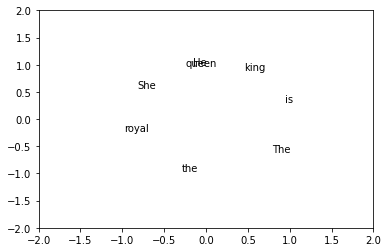

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlim(left=-2, right=2)
ax.set_ylim(bottom=-2, top=2)

for word in words:
    print(word, vectors[word2int[word]])
    ax.annotate(word, (vectors[word2int[word]][0], vectors[word2int[word]][1]))
    
plt.show()

# 뉴스데이터 skip_gram

In [50]:
# 파일 불러오기
import pandas as pd
df_news = pd.read_csv("news.csv")

In [51]:
# 문장으로 나누기
sentences = df_news['content'].apply(lambda x: x.split(".    ")).tolist()
from konlpy.tag import Mecab
mecab = Mecab()

corpus = [mecab.morphs(sent) for para in sentences for sent in para]

In [53]:
# Word2Vec 모델 생성
from gensim.models import Word2Vec
model = Word2Vec(sentences=corpus, vector_size=100, alpha=0.025, window=5, min_count=1, workers=4)

In [54]:
# 키 리스트 확인
model.wv.key_to_index

{'.': 0,
 '이': 1,
 '다': 2,
 '는': 3,
 '에': 4,
 '을': 5,
 '의': 6,
 '은': 7,
 '가': 8,
 '를': 9,
 '고': 10,
 '"': 11,
 '하': 12,
 '했': 13,
 ',': 14,
 '으로': 15,
 '있': 16,
 '것': 17,
 '금리': 18,
 '(': 19,
 '한': 20,
 ')': 21,
 '%': 22,
 '로': 23,
 '도': 24,
 '에서': 25,
 '1': 26,
 '시장': 27,
 '적': 28,
 '들': 29,
 '-': 30,
 '년': 31,
 '월': 32,
 '2': 33,
 '일': 34,
 '3': 35,
 '과': 36,
 '할': 37,
 '원': 38,
 '등': 39,
 '성': 40,
 '인': 41,
 '지': 42,
 '되': 43,
 '달러': 44,
 '기': 45,
 '경제': 46,
 '와': 47,
 '5': 48,
 '수': 49,
 '상승': 50,
 '금융': 51,
 '미국': 52,
 '4': 53,
 "'": 54,
 '은행': 55,
 '0': 56,
 '며': 57,
 '보다': 58,
 '만': 59,
 '게': 60,
 '하락': 61,
 '면서': 62,
 '해': 63,
 '화': 64,
 '억': 65,
 '전망': 66,
 '말': 67,
 '어': 68,
 '않': 69,
 '인상': 70,
 '면': 71,
 '채권': 72,
 '지수': 73,
 '됐': 74,
 '6': 75,
 '10': 76,
 '다고': 77,
 '가능': 78,
 '될': 79,
 '물': 80,
 '지만': 81,
 '투자': 82,
 '정책': 83,
 '다는': 84,
 '예상': 85,
 '기준': 86,
 '국채': 87,
 '대한': 88,
 '경기': 89,
 '까지': 90,
 '7': 91,
 '엔': 92,
 '률': 93,
 '대출': 94,
 'kr': 95,
 'co': 96,
 '지난': 

In [55]:
# '금리' 임베딩 확인
word_embedding = model.wv["금리"]

In [56]:
# '금리'와 유사한 단어 찾기
sims = model.wv.most_similar('금리', topn=10)

In [58]:
sims

[('시중금리', 0.713452935218811),
 ('예정이율', 0.5228966474533081),
 ('이율', 0.5121126770973206),
 ('이자율', 0.511782169342041),
 ('지준율', 0.49705636501312256),
 ('ㅇ콜금리', 0.47652584314346313),
 ('가격', 0.46654245257377625),
 ('WINE', 0.4453544318675995),
 ('ㆍ예금금리의', 0.4406014680862427),
 ('隔月', 0.44023120403289795)]